# TO RUN : importS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set(font_scale = 1.3, rc = {'figure.figsize':(10,6)})
sns.set_palette('colorblind')

# 1- FIRST STATISTICS
Here, we try to extract a few basic statistics to make sure we have the necessary data to perform the project. Indeed, after selecting the quotations of interests (the ones related to arms in the USA), we want to make sure these datas are sufficiently numerous to perform an actual study on the right to bear arms in the USA. We also want to check if our research questions are reasonnnable and can be solved from our data. <br>
<br>
First, we get a sense of the quantity of actual quotations speaking about arms, and we compute its share in the total quotes dataset of 2017.

### Load the data
The new dataset `quotes-2017-extended.json` can be loaded from here.

In [2]:
gunquotes = pd.read_json('data/quotes-2017-extended.json.bz2', lines=True, compression='bz2')
gunquotes

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,gender,nationality,occupation,age,ethnic_group,party,religion
0,2017-03-26-000661,"A big burglar, I never really knew him to carr...",Brian Andrews,"[Q2924842, Q4962982, Q4962983]",2017-03-26 17:01:19,1,"[[Brian Andrews, 0.7167], [Tony Fiore, 0.1666]...",[http://www.providencejournal.com/news/2017032...,E,male,[United States of America],[singer],41.0,None,None,None
1,2017-05-22-015293,"Congress, investigate Seth Rich Murder! @ Juli...",Sean Hannity,[Q557730],2017-05-22 14:40:47,3,"[[Sean Hannity, 0.8718], [None, 0.0946], [Kim ...",[http://news.yahoo.com/news/seth-rich-conspira...,E,male,[United States of America],"[radio personality, television presenter, jour...",59.0,None,[Conservative Party of New York State],[Catholicism]
2,2017-09-11-088873,similar rules for whether you can own a gun an...,Kris Kobach,[Q6437211],2017-09-11 22:17:52,2,"[[Kris Kobach, 0.5138], [John Lott, 0.3198], [...",[http://www.kansas.com/news/politics-governmen...,E,male,[United States of America],[lawyer],55.0,None,[Republican Party],None
3,2017-08-10-034688,He keeps getting better each day at practice. ...,Ruffin McNeill,[Q7377923],2017-08-10 01:00:45,1,"[[Ruffin McNeill, 0.7703], [None, 0.2297]]",[http://newsok.com/marquise-overton-expected-t...,E,male,[United States of America],"[head coach, American football player]",63.0,None,None,None
4,2017-11-19-055725,The easiest one is to make guns better for hom...,David Hemenway,[Q1107796],2017-11-19 14:50:20,1,"[[David Hemenway, 0.791], [None, 0.209]]",[http://www.wbur.org/npr/462252799/research-su...,E,male,[United States of America],"[economist, university teacher]",76.0,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36457,2017-10-04-005756,All things that make America safer and don't i...,Lindsey Graham,[Q22212],2017-10-04 21:19:20,1,"[[Lindsey Graham, 0.8846], [None, 0.1154]]",[http://www.wandtv.com/story/36523093/congress...,E,male,[United States of America],"[politician, air force officer, lawyer, county...",66.0,None,[Republican Party],[Southern Baptist Convention]
36458,2017-10-02-005046,already this year there have been more mass sh...,Chris Murphy,"[Q1077594, Q20022484, Q2964809, Q5107535, Q510...",2017-10-02 15:00:00,2,"[[Chris Murphy, 0.8709], [None, 0.12], [Elizab...",[http://commondreams.org/news/2017/10/02/messa...,E,male,[United States of America],"[politician, lawyer]",48.0,[Irish people],[Democratic Party],[Protestantism]
36459,2017-06-03-012435,"Evolution is also the basis of racism, [ and ]...",David Whitney,[Q215478],2017-06-03 00:00:00,3,"[[David Whitney, 0.6764], [None, 0.3236]]",[http://www.patheos.com/blogs/friendlyatheist/...,E,male,[United States of America],"[screenwriter, film director, film producer, j...",77.0,None,None,None
36460,2017-08-29-047666,I t's a movie about growing up and about gener...,Don Hahn,"[Q1072843, Q5292728]",2017-08-29 18:10:00,2,"[[Don Hahn, 0.8057], [None, 0.1943]]",[http://hellogiggles.com/reviews-coverage/movi...,E,male,[United States of America],"[film producer, screenwriter, film director, a...",65.0,None,None,None


In [3]:
nblines_gunquotes = gunquotes.shape[0]
nbtot_gunquotes = gunquotes['numOccurrences'].sum()
print(nblines_gunquotes)
print(nbtot_gunquotes)

36462
212199


In [ ]:
share_gunquotes = 100 * nblines_gunquotes / nblines_totquotes
sharetot_gunquotes = 100 * nbtot_gunquotes / nbtot_totquotes
print(share_gunquotes)
print(sharetot_gunquotes)

**Analysis :** <br>
The new dataset (with only selected quotes) contain 36462 different quotes, some of which are quoted in several articles. Thus, there is a total number of 212199 quotes found in the 2017 newspapers that are related to our topic. <br>
This represent a share of     % of the total quotations of 2017. Even if this share is very small, the size of the original 2017 dataset being very huge, it is not surprising and 36462 different quotations is already quite a lot of data for 1 year for our project.

### A first timeline for 2017

In [4]:
# Useful functions for the following plots

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

#### 'Gun quotes' timeline per month

dateWithoutTime
1       591
2      4222
3     12014
4     16151
5     12107
6     43104
7     13109
8     16648
9     11135
10    41903
11    27478
12    13737
Name: numOccurrences, dtype: int64
212199


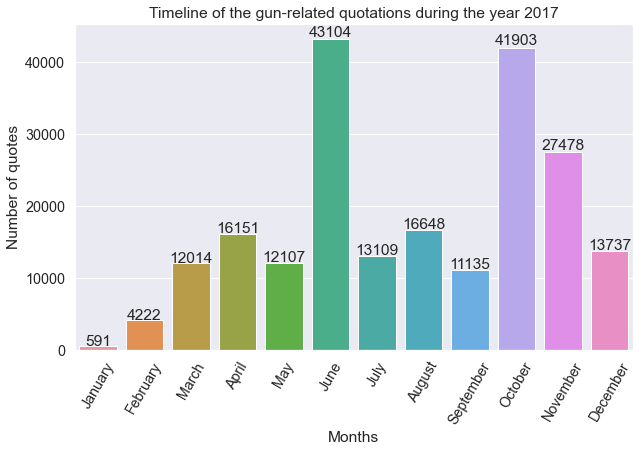

In [6]:
## Plot of the nb of quotes related to guns in function of the month

gunquotes['dateWithoutTime'] = gunquotes['date'].dt.normalize()

quotes_perMonth = gunquotes.groupby(gunquotes['dateWithoutTime'].dt.month).numOccurrences.sum()
print(quotes_perMonth)
print(quotes_perMonth.sum())
# ax = sns.barplot(x=gunquotes.groupby(gunquotes["dateWithoutTime"].dt.month), y=gunquotes.groupby(gunquotes['dateWithoutTime'].dt.month).numOccurrences.sum())#, data=gunquotes)
ax = sns.barplot(x=np.linspace(1,12,12), y=gunquotes.groupby(gunquotes['dateWithoutTime'].dt.month).numOccurrences.sum())#, data=gunquotes)
# ax = sns.barplot(x=quotes_perMonth.index, y=quotes_perMonth)
sns.set_color_codes("colorblind")
ax.set_xlabel('Months')
ax.set_ylabel('Number of quotes')
ax.set_title('Timeline of the gun-related quotations during the year 2017')
ax.set_xticklabels(labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.xticks(rotation=60)
show_values(ax)
plt.show()


**Analysis :** <br>
The barplot reveals an unexpected big amount of quotations speaking about guns in the months of June and October. One can guess that this is due to an event that occured in this month. Indeed, for example the amounts of quotes in October can be explianed by the Las Vegas shooting of the 1st of October. To verfiy this guess we will look further at the distribution of the quotes in thess 2 months.

#### Zoom on the month of June

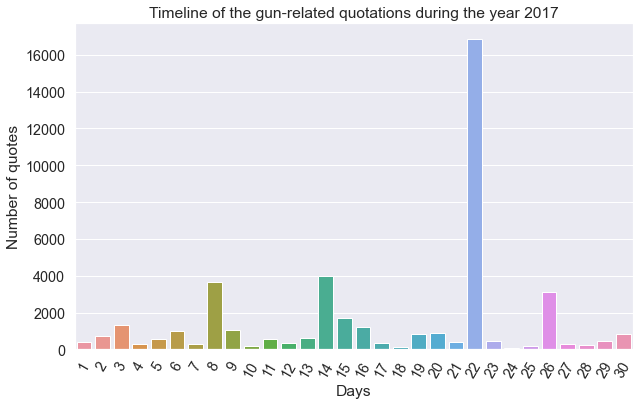

In [12]:
## Plot of the nb of quotes related to guns in function of the date : zoom on JUNE

june = gunquotes[(gunquotes['date'].dt.month == 6)]

ax = sns.barplot(x=np.linspace(1,30,30, dtype='int'), y=june.groupby(june['dateWithoutTime']).numOccurrences.sum())#, data=gunquotes)
sns.color_palette("tab10")
ax.set_xlabel('Days')
ax.set_ylabel('Number of quotes')
ax.set_title('Timeline of the gun-related quotations during the year 2017')
plt.xticks(rotation=60)
# show_values(ax)
plt.show()

## Explanation :
## https://www.nytimes.com/2017/06/26/us/politics/supreme-court-guns-public-california.html
## https://www.pewresearch.org/social-trends/2017/06/22/americas-complex-relationship-with-guns/
## Fusillade de l'entrainement républicain du match de baseball du Congrès le 14 juin 2017 : https://fr.wikipedia.org/wiki/Fusillade_de_l%27entrainement_r%C3%A9publicain_du_match_de_baseball_du_Congr%C3%A8s
## Pizzagate shooters sentenced to 4 years of prison on the 22th of June 2017 : https://edition.cnn.com/2017/06/22/politics/pizzagate-sentencing/index.html

In [15]:
gunquotes[(gunquotes['date'].dt.month == 6)]
june[(june['date'].dt.day==22)].numOccurrences.sum()
june[(june['date'].dt.day!=22)].numOccurrences.mean()

7.603768115942029

In [57]:
june_22 = june[(june['date'].dt.day==22)]
june_22.quotation.iloc[1]
# june_22[(june_22.quotation.str.contains('pedophilia'))].numOccurrences.sum()
june[(june.quotation.str.contains('sentenced'))].quotation
# june_22[(june_22.quotation.str.contains('prison'))].numOccurrences.sum()
gunquotes[(gunquotes.quotation.str.contains('Last month, Joshua Brandon Vallum'))]
# gunquotes.iloc[19414].quotation
# gunquotes.iloc[31416].urls
# june[(june.quotation.str.contains('baseball'))].numOccurrences.sum()
# june[(june.quotation.str.contains('baseball'))].iloc[0].quotation

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,gender,nationality,occupation,age,ethnic_group,party,religion,dateWithoutTime
8250,2017-10-16-136588,We have and will continue to enforce hate crim...,Jeff Sessions,[Q358443],2017-10-16 18:55:01,1,"[[Jeff Sessions, 0.9109], [None, 0.0891]]",[http://freebeacon.com/issues/sessions-sends-f...,E,male,[United States of America],"[politician, lawyer, lawyer, political scientist]",74.0,None,[Republican Party],[Methodism],2017-10-16
19414,2017-06-30-066125,"Last month, Joshua Brandon Vallum was sentence...",Jeff Sessions,[Q358443],2017-06-30 15:14:28,1,"[[Jeff Sessions, 0.635], [None, 0.365]]",[http://www.newnownext.com/jeff-sessions-enfor...,E,male,[United States of America],"[politician, lawyer, lawyer, political scientist]",74.0,None,[Republican Party],[Methodism],2017-06-30
23347,2017-06-29-131630,We have and will continue to enforce hate crim...,Jeff Sessions,[Q358443],2017-06-29 15:59:46,2,"[[Jeff Sessions, 0.8184], [None, 0.1816]]",[http://freebeacon.com/issues/sessions-address...,E,male,[United States of America],"[politician, lawyer, lawyer, political scientist]",74.0,None,[Republican Party],[Methodism],2017-06-29
31416,2017-06-29-071546,"Last month, Joshua Brandon Vallum was sentence...",Jeff Sessions,[Q358443],2017-06-29 20:17:00,4,"[[Jeff Sessions, 0.7653], [None, 0.2128], [Pre...",[http://www.christianpost.com/news/trump-justi...,E,male,[United States of America],"[politician, lawyer, lawyer, political scientist]",74.0,None,[Republican Party],[Methodism],2017-06-29


**Analysis :**  
The timeline for June is quite interesting. There is a big peak in the quantity of quotes for the day 22 : 16 871 quotes published in the newspapers, while the other days have a mean of approximately 8 quotes. We were quite supprised by this result as we didn't remember of any event related to guns in this period. After a few reaserch on the web, we found that the 22th of June 2017 corresponds to the day that the 'Pizzagate' murderer (4th December 2016) was sentenced to 4 years of prison. We think that the big amount of quotes for this day, is indeed related to this sentence since a lot of these quotation contains key words about this topic.  
Sources : https://www.nytimes.com/2017/06/22/us/pizzagate-attack-sentence.html ; https://en.wikipedia.org/wiki/Pizzagate_conspiracy_theory   

There was also a shooting during a baseball practice of the Congressional Baseball Game for Charity on the 14th of June 2017. This explains the also quite large amount of data for this day and the large amount of quotations (201) containing the word *"baseball"*.  
Source : https://en.wikipedia.org/wiki/Congressional_baseball_shooting

#### Zoom on the month of October

In [3]:
## Plot of the nb of quotes related to guns in function of the date : zoom on OCTOBER

october = gunquotes[(gunquotes['date'].dt.month == 10)]
# nb = october.groupby(october['dateWithoutTime']).numOccurrences.sum()
# print(nb.sum())

ax = sns.barplot(x=np.linspace(1,31,31, dtype='int'), y=october.groupby(october['dateWithoutTime']).numOccurrences.sum())#, data=gunquotes)
sns.color_palette("tab10")
ax.set_xlabel('Days')
ax.set_ylabel('Number of quotes')
ax.set_title('Timeline of the gun-related quotations during the year 2017')
#ax.set_xticklabels(labels=labs)
plt.xticks(rotation=60)
show_values(ax)
plt.show()

## Explanation : Las Vegas shooting on the 1st of October 2017

NameError: name 'gunquotes' is not defined

**Analysis :**  
Most of the quotations of the mmonth of October were found in articles of the 2nd of October, the day after the mass shooting of Las Vegas. This thus confirms our guess that these articles spoke about this event. The following days, also show a higher amount of quotations, revealing that the medias continued to talk about the tragedy in the following days.

# 2- MATCHING OF THE DATASET FOR SENTIMENT ANALYSIS

### Matching of the dataset 

### Sentiment analysis

# Conclusions on the following of the project  
TO COMPLETE